## Lets Do Sentiment Analysis on IMDB dataset by extracting BERT Embeddings

## Import Section

In [1]:
!pip install tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 KB 42.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 57.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 69.1 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully u

In [2]:
!pip install simpletransformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.5/250.5 KB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 KB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 KB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 13.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━

In [3]:
!pip install keras-tuner 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 KB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.6 MB/s eta 0:00:00


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import sklearn as skl
import glob
import re
import io
import os
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
tqdm.pandas()
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow as tf
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from simpletransformers.language_representation import RepresentationModel
import time
from tensorflow.keras.layers import Dense,Input,Activation,Dropout,BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,LearningRateScheduler,ReduceLROnPlateau,TensorBoard
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score,log_loss,confusion_matrix,classification_report
import keras_tuner as kt
from tensorflow import keras
from wordcloud import WordCloud
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

## Let pull the dataset from kaggle

In [5]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir ~/.kaggle dataset
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d team-ai/spam-text-message-classification
!unzip spam-text-message-classification.zip -d dataset

Saving kaggle.json to kaggle.json
100% 208k/208k [00:00<00:00, 560kB/s]
100% 208k/208k [00:00<00:00, 560kB/s]
Archive:  spam-text-message-classification.zip
  inflating: dataset/SPAM text message 20170820 - Data.csv  


In [6]:
data = pd.read_csv('/content/dataset/SPAM text message 20170820 - Data.csv')
data.head()


,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
data.isnull().sum()

Category    0
Message     0
dtype: int64

In [8]:
data['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

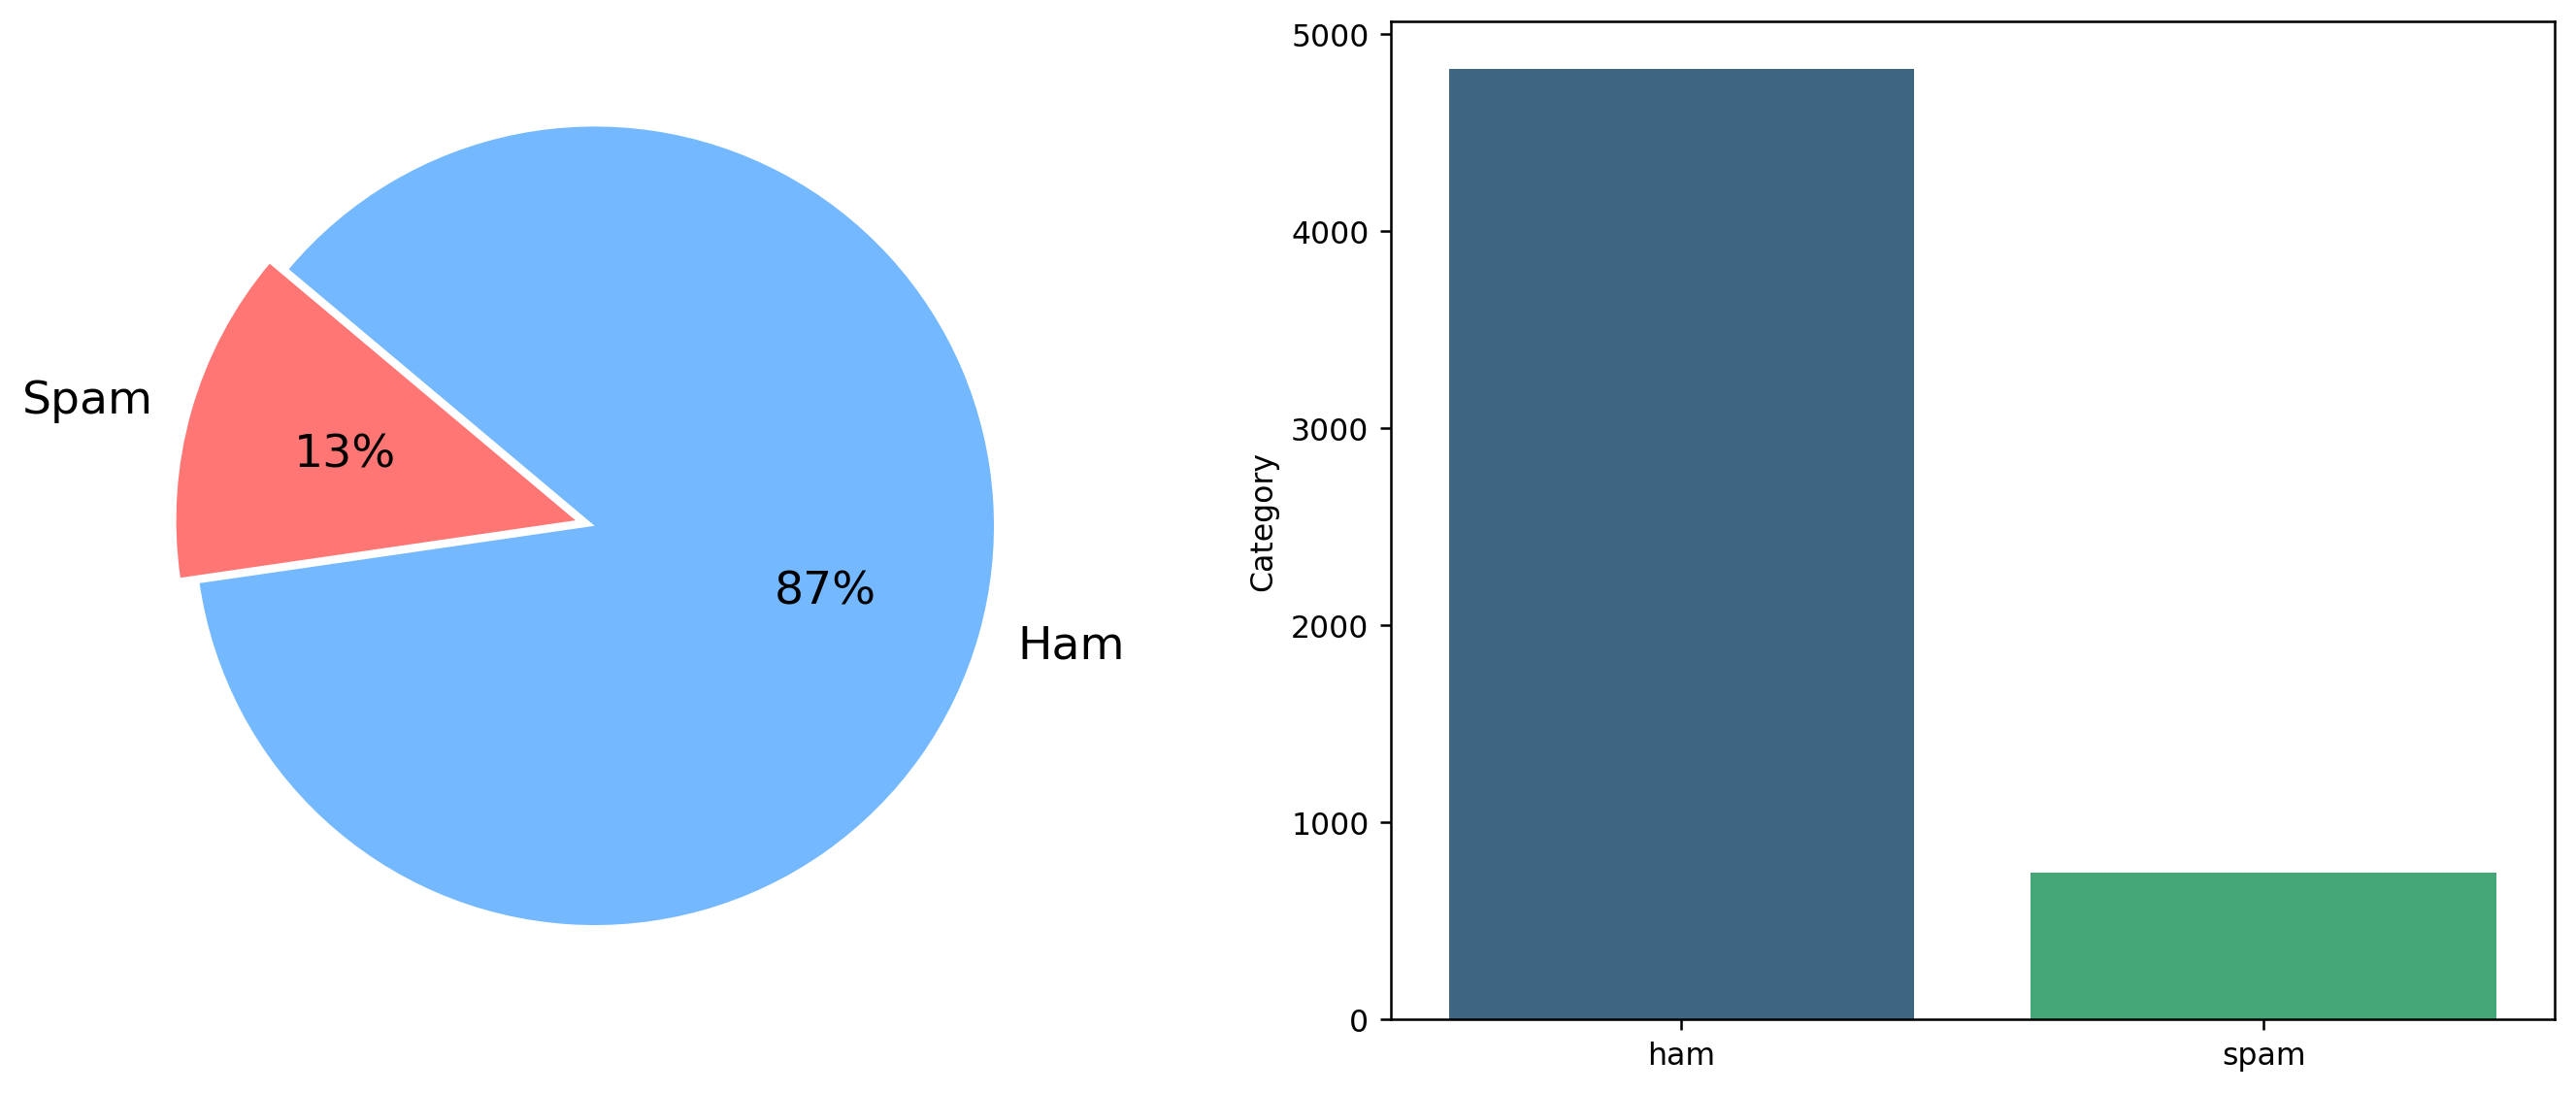

In [9]:
labels = ['Spam', 'Ham']
sizes = [747, 4825]
custom_colours = ['#ff7675', '#74b9ff']
plt.figure(figsize=(15, 6), dpi=227)
plt.subplot(1, 2, 1)
plt.pie(sizes, labels = labels, textprops={'fontsize': 15}, startangle=140, 
       autopct='%1.0f%%', colors=custom_colours, explode=[0, 0.05])
plt.subplot(1, 2, 2)
sns.barplot(x = data['Category'].unique(), y = data['Category'].value_counts(), palette= 'viridis')
plt.show()

## lets do some preprocessing

In [10]:
data['Total Words'] = data['Message'].apply(lambda x: len(x.split()))
def count_total_words(text):
    char = 0
    for word in text.split():
        char += len(word)
    return char
data['Total Chars'] = data["Message"].apply(count_total_words)

In [11]:
data.head()

,Category,Message,Total Words,Total Chars
0,ham,"Go until jurong point, crazy.. Available only ...",20,92
1,ham,Ok lar... Joking wif u oni...,6,24
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,128
3,ham,U dun say so early hor... U c already then say...,11,39
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,49


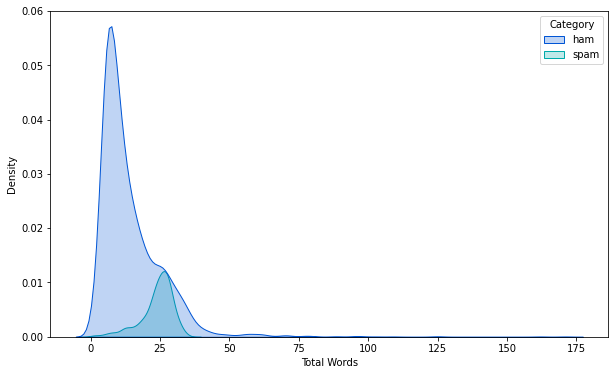

In [12]:
plt.figure(figsize = (10, 6))
sns.kdeplot(x = data['Total Words'], hue= data['Category'], palette= 'winter', shade = True)
plt.show()

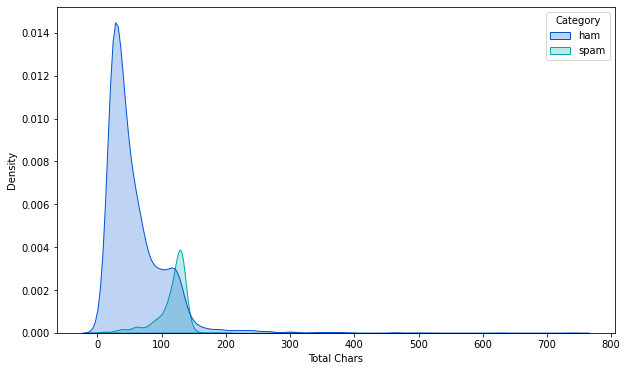

In [13]:
plt.figure(figsize = (10, 6))
sns.kdeplot(x = data['Total Chars'], hue= data['Category'], palette= 'winter', shade = True)
plt.show()

### Lets convert to lower case

In [14]:
def convert_lowercase(text):
    text = text.lower()
    return text

data['Message'] = data['Message'].apply(convert_lowercase)

In [15]:
def remove_url(text):
    re_url = re.compile('https?://\S+|www\.\S+')
    return re_url.sub('', text)

data['Message'] = data['Message'].apply(remove_url)

In [16]:
import string
exclude = string.punctuation

def remove_punc(text):
    return text.translate(str.maketrans('', '', exclude))

data['Message'] = data['Message'].apply(remove_punc)

In [17]:
data['Total Words After Transformation'] = data['Message'].apply(lambda x: len(x.split()))

In [18]:
data.head()

,Category,Message,Total Words,Total Chars,Total Words After Transformation
0,ham,go until jurong point crazy available only in ...,20,92,20
1,ham,ok lar joking wif u oni,6,24,6
2,spam,free entry in 2 a wkly comp to win fa cup fina...,28,128,28
3,ham,u dun say so early hor u c already then say,11,39,11
4,ham,nah i dont think he goes to usf he lives aroun...,13,49,13


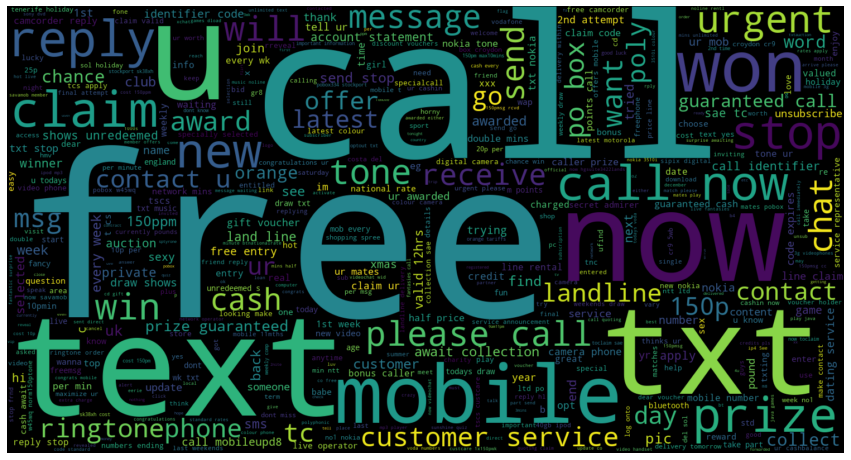

In [19]:
text = " ".join(data[data['Category'] == 'spam']['Message'])
plt.figure(figsize = (15, 10))
wordcloud = WordCloud(max_words=500, height= 800, width = 1500,  background_color="black", colormap= 'viridis').generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

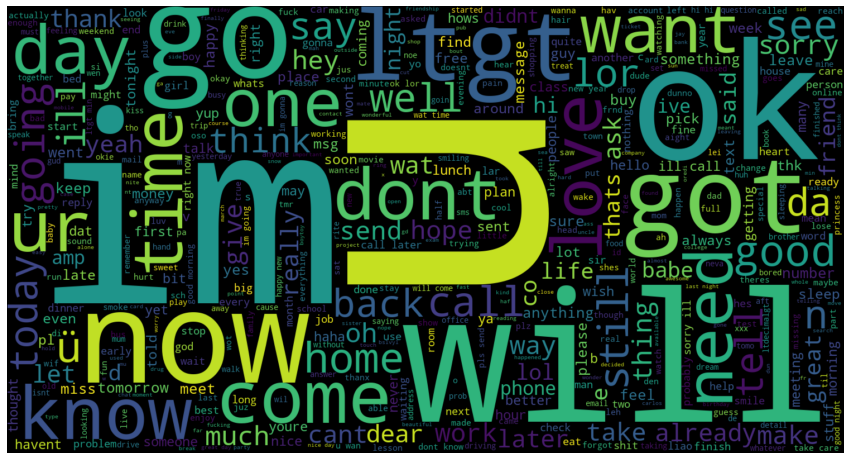

In [20]:
text = " ".join(data[data['Category'] == 'ham']['Message'])
plt.figure(figsize = (15, 10))
wordcloud = WordCloud(max_words=500, height= 800, width = 1500,  background_color="black", colormap= 'viridis').generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [21]:
from sklearn.preprocessing import LabelEncoder
X = data["Message"]
y = data['Category'].values
encoder = LabelEncoder()
y = encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42, stratify = y)

In [22]:
X_train

184                                he will you guys close
2171    can i please come up now imin towndontmatter i...
5422                    ok ksry i knw 2 sivatats y i askd
4113                              ill see but prolly yeah
4588    ill see if i can swing by in a bit got some th...
                              ...                        
1932                       what pa tell me i went to bath
5316                             jus finish watching tv u
2309    moby pub quizwin a £100 high street prize if u...
1904    free entry in 2 a weekly comp for a chance to ...
762     we are at grandmas oh dear u still ill i felt ...
Name: Message, Length: 4457, dtype: object

In [23]:
y_train

array([0, 0, 0, ..., 1, 1, 0])

### Lets see the word Charecteristics of Train data

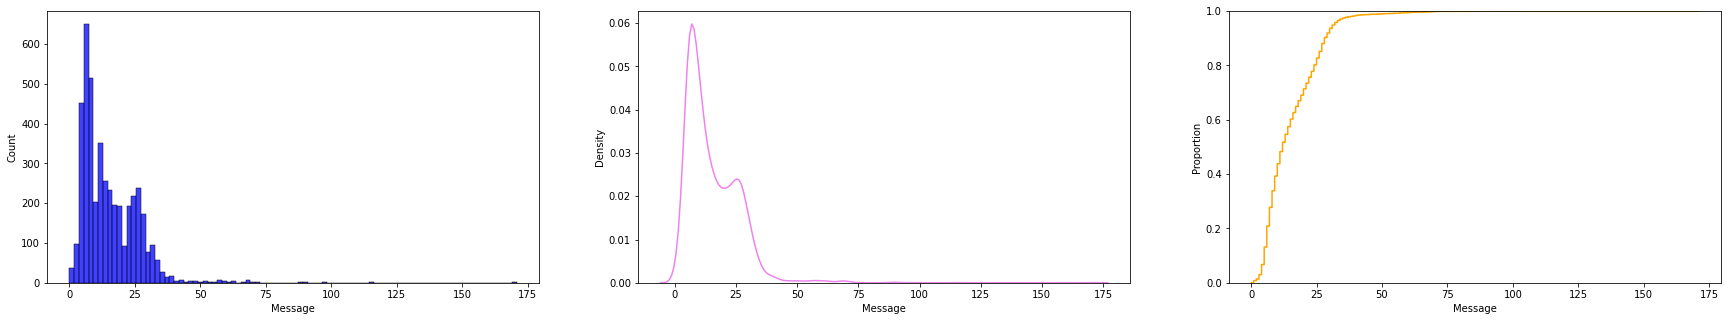

In [24]:
review_lengths = X_train.str.split().apply(len)
fig, axs = plt.subplots(ncols=3,figsize=(30,5))
a = sns.histplot(data = review_lengths,ax=axs[0],color = 'blue')
b = sns.kdeplot(data = review_lengths,ax=axs[1],color = 'violet')
c = sns.ecdfplot(data = review_lengths,ax=axs[2],color = 'orange')
plt.show()

### Lets see the word Charecteristics of test data

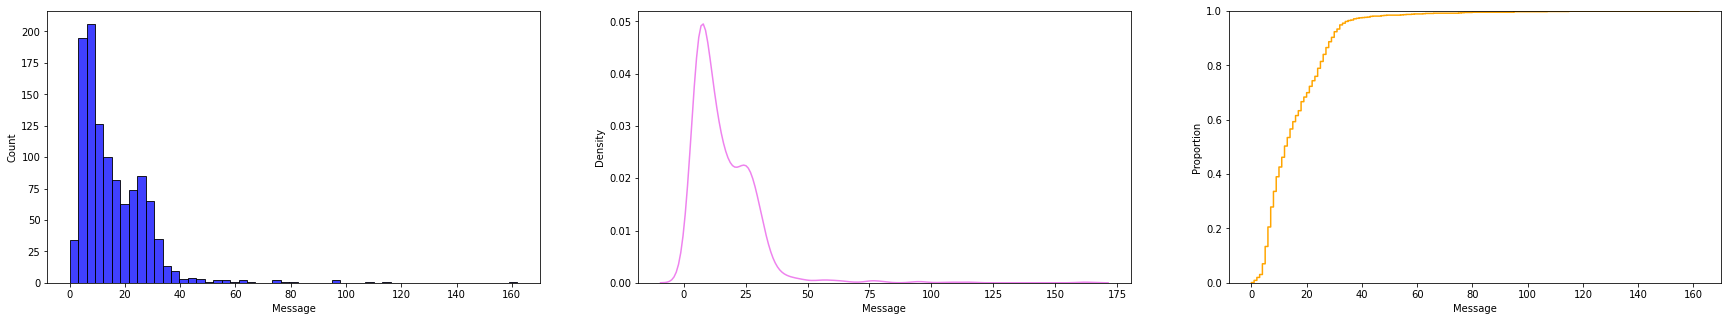

In [25]:
review_lengths = X_test.str.split().apply(len)
fig, axs = plt.subplots(ncols=3,figsize=(30,5))
a = sns.histplot(data = review_lengths,ax=axs[0],color = 'blue')
b = sns.kdeplot(data = review_lengths,ax=axs[1],color = 'violet')
c = sns.ecdfplot(data = review_lengths,ax=axs[2],color = 'orange')
plt.show()

## Lets take max sequence length as 100

In [26]:
def make_max_sequence_len(text):
  text = ' '.join(text.split(' ')[:100])
  return text

In [27]:
X_train = X_train.progress_apply(make_max_sequence_len)
X_test = X_test.progress_apply(make_max_sequence_len)

100%|██████████| 1115/1115 [00:00<00:00, 316545.89it/s]


## Lets  construct the bert model

In [28]:
from transformers import TFBertModel,BertConfig,AutoTokenizer

config = BertConfig.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english", output_hidden_states=True)
bert_model = TFBertModel.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english", config=config)
checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)


Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing TFBertModel: ['pre_classifier', 'classifier', 'distilbert', 'dropout_19']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english and are newly initialized: ['bert']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

## Lets Generate Sentence Embeddings

In [33]:
X_train_Sentence_vectors = []
for i in tqdm(X_train):
  X_train_inputs = tokenizer(list(i), padding=True, truncation=True, return_tensors="tf")["input_ids"]
  train_outputs = bert_model(X_train_inputs)
  X_train_Sentence_vectors.append(train_outputs[1])

 94%|█████████▍| 4184/4457 [13:17<00:52,  5.25it/s]


IndexError: ignored

In [40]:
X_test_Sentence_vectors = []
for i in tqdm(X_test):
  X_test_inputs = tokenizer(list(i), padding=True, truncation=True, return_tensors="tf")["input_ids"]
  test_outputs = bert_model(X_test_inputs)
  X_test_Sentence_vectors.append(test_outputs[1])

Execution time: 0.0644779364267985 Minutes


In [41]:
X_train_Sentence_vectors.shape

(4457, 768)

In [43]:
import pickle
# Open a file and use dump()
with open('X_train_Sentence_vectors.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(X_train_Sentence_vectors, file)
# Open a file and use dump()
with open('X_test_Sentence_vectors.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(X_test_Sentence_vectors, file)

In [44]:
# Open the file in binary mode
with open('X_train_Sentence_vectors.pkl', 'rb') as file: 
    # Call load method to deserialze
    X_train_Sentence_vectors = pickle.load(file)
with open('X_test_Sentence_vectors.pkl', 'rb') as file: 
    # Call load method to deserialze
    X_test_Sentence_vectors = pickle.load(file)

## Lets create a model with hyper parameter tuning

In [45]:
output_dim = 1
def build_model(hp):
  model = keras.Sequential()
  counter = 0
  for i in range(hp.Int('num_layers',min_value = 1, max_value = 5)):
    if counter ==0:
      model.add(
          Dense(
              hp.Int('units'+str(i), min_value = 400, max_value = 700,step =100),
              activation = hp.Choice('activation'+str(i),values=['relu','tanh','sigmoid']),
              kernel_initializer = hp.Choice('initialiser'+str(i),values = ['he_normal','glorot_normal']),
              input_dim = X_train_Sentence_vectors.shape[1]

          )
          )
    elif counter >=3:
      model.add(
          Dense(
              hp.Int('units'+str(i), min_value = 200, max_value = 500,step =100),
              activation = hp.Choice('activation'+str(i),values=['relu','tanh','sigmoid']),
              kernel_initializer = hp.Choice('initialiser'+str(i),values = ['he_normal','glorot_normal'])
          )
          )
      model.add(
          Dropout(hp.Choice('dropout'+str(i),values=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]))
          )
      model.add(
          BatchNormalization(epsilon = hp.Choice('BatchNorm'+str(i),values = [0.01,0.001]))
      )
    else:
      model.add(
          Dense(
              hp.Int('units'+str(i), min_value = 50, max_value = 200,step =50),
              activation = hp.Choice('activation'+str(i),values=['relu','tanh','sigmoid']),
              kernel_initializer = hp.Choice('initialiser'+str(i),values = ['he_normal','glorot_normal'])
          )
          )
    counter += 1
  model.add(Dense(output_dim,activation = 'softmax'))
  model.compile(optimizer = hp.Choice('optimiser', values = ['rmsprop','sgd','adam','nadam']),loss='binary_crossentropy',metrics=['accuracy'])
  return model

In [46]:
tuner = kt.RandomSearch(build_model,objective = 'val_accuracy',max_trials = 3, directory = "hyperparametertuning",project_name = 'binaryclassification_run3')

In [48]:
tuner.search(X_train_Sentence_vectors,y_train,epochs = 5,validation_split = 0.2)

Trial 3 Complete [00h 00m 04s]
val_accuracy: 0.1569506675004959

Best val_accuracy So Far: 0.1569506675004959
Total elapsed time: 00h 00m 17s


In [50]:
tuner.get_best_hyperparameters()[0].values

{'num_layers': 3,
 'units0': 400,
 'activation0': 'tanh',
 'initialiser0': 'he_normal',
 'optimiser': 'adadelta',
 'units1': 50,
 'activation1': 'relu',
 'initialiser1': 'he_normal',
 'units2': 50,
 'activation2': 'relu',
 'initialiser2': 'he_normal'}

### We can rebuild model with the given parameters or can use the model directly from the tuner

In [51]:
best_model = tuner.get_best_models(num_models = 1)[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 400)               410000    
                                                                 
 dense_1 (Dense)             (None, 50)                20050     
                                                                 
 dense_2 (Dense)             (None, 50)                2550      
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 432,651
Trainable params: 432,651
Non-trainable params: 0
_________________________________________________________________


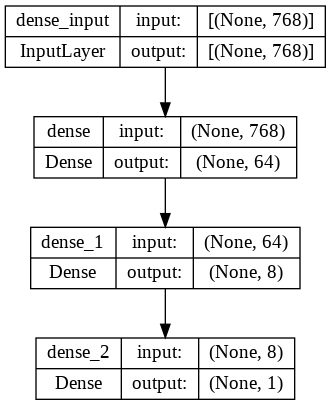

In [34]:
plot_model(best_model, show_shapes=True)

In [35]:
filepath="model_save/weights-{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',  verbose=1, save_best_only=True, mode='auto')

In [36]:
earlystop = EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=3, verbose=1)

In [37]:
# Load the TensorBoard notebook extension
import datetime
%load_ext tensorboard
log_dir = os.path.join("logs",'fits', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1,write_graph=True)
%reload_ext tensorboard

In [38]:
nb_epoch = 10
history_MLP = best_model.fit(X_train_Sentence_vectors, y_train, steps_per_epoch=500, epochs=nb_epoch, verbose=1, validation_data=(X_cv_Sentence_vectors, y_cv),callbacks = [earlystop,checkpoint,tensorboard_callback]) 

Epoch 1/10
497/500 [============================>.] - ETA: 0s - loss: 0.4200 - accuracy: 0.5016
Epoch 1: val_accuracy improved from -inf to 0.49050, saving model to model_save/weights-01-0.4905.hdf5
500/500 [==============================] - 3s 4ms/step - loss: 0.4202 - accuracy: 0.5016 - val_loss: 0.4334 - val_accuracy: 0.4905
Epoch 2/10
486/500 [============================>.] - ETA: 0s - loss: 0.4078 - accuracy: 0.5023
Epoch 2: val_accuracy did not improve from 0.49050
500/500 [==============================] - 2s 3ms/step - loss: 0.4067 - accuracy: 0.5016 - val_loss: 0.4260 - val_accuracy: 0.4905
Epoch 3/10
482/500 [===========================>..] - ETA: 0s - loss: 0.3925 - accuracy: 0.5007
Epoch 3: val_accuracy did not improve from 0.49050
500/500 [==============================] - 2s 3ms/step - loss: 0.3921 - accuracy: 0.5016 - val_loss: 0.4188 - val_accuracy: 0.4905
Epoch 4/10
486/500 [============================>.] - ETA: 0s - loss: 0.3886 - accuracy: 0.5026
Epoch 4: val_accur

In [39]:
def metrics(y_test,y_pred,y_prob):
  accuracy = accuracy_score(y_test,y_pred)
  f1score = f1_score(y_test,y_pred,average = 'micro')
  logloss = 0
  for test_row,pred_row in zip(y_test,y_prob):
    index = np.argmax(np.array(test_row))
    logloss+=np.log(np.array(pred_row[index]))
  logloss = -(1/y_test.shape[0])*logloss
  print("accuracy score :",accuracy)
  print("f1 score :",f1score)
  print("log loss :",logloss)
  print('classification report : \n', classification_report(y_test,y_pred))
  print('*********** confusion matrx ***********')
  sns.heatmap(confusion_matrix(y_test,y_pred),annot = True, cmap = 'Blues',fmt = '.2f')
  plt.show()

In [40]:
score = best_model.evaluate(X_test_Sentence_vectors, y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Test score: 0.3882509469985962
Test accuracy: 0.5024999976158142


In [ ]:
y_pred = best_model.predict(X_test_Sentence_vectors) 
y_pred

In [ ]:
y_pred = best_model.predict(X_test_Sentence_vectors) 
metrics(y_test,y_pred)

16/16 [==============================] - 0s 5ms/step


AxisError: ignored